<img align="right" src="https://www.nih-cfde.org/wp-content/uploads/2020/11/CFDE_logo-color-web.png" width="100">

<img align="right" src="https://druggablegenome.net/IDG_Images_Index/IDGLOGO.png" width="300">


# CFDE-IDG RefMet Cheminfo Test

* https://www.nih-cfde.org/
* https://www.metabolomicsworkbench.org/databases/refmet/index.php
* http://druggablegenome.net

## Imports

In [1]:
import sys,os,io,pandas,base64,requests,urllib.request
import pandas as pd
from IPython.display import Image
from IPython.display import SVG
from IPython.core.display import display, HTML
import psycopg2,psycopg2.extras
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

## DB credentials

In [2]:
DBHOST = "localhost"
DBPORT = 5432
DBNAME = "refmet"
DBUSR = "www"
DBPW = "foobar"

In [3]:
dsn = (f"host='{DBHOST}' port='{DBPORT}' dbname='{DBNAME}' user='{DBUSR}' password='{DBPW}'")
dbcon = psycopg2.connect(dsn)
dbcon.cursor_factory = psycopg2.extras.DictCursor

In [4]:
pd.read_sql("SELECT COUNT(*) FROM main", dbcon)


,count
0,154677


In [5]:
sql = """
SELECT
	tanimoto_sml(rdkit_fp(mol_from_smiles('NCCc1ccc(O)c(O)c1'::cstring)),m.fp) AS "sim",
	m.pubchem_cid,
	s.refmet_name,
	mol_to_smiles(m.mol) AS "smiles"
FROM
	mols m
JOIN
	main s ON (s.pubchem_cid = m.pubchem_cid)
WHERE
	rdkit_fp(mol_from_smiles('NCCc1ccc(O)c(O)c1'::cstring))%m.fp
ORDER BY
	sim DESC"""
hits = pd.read_sql(sql, dbcon)
hits = hits.iloc[:12,]
hits

,sim,pubchem_cid,refmet_name,smiles
0,1.000000,681,Dopamine,NCCc1ccc(O)c(O)c1
1,0.921986,114772,5-Hydroxydopamine,NCCc1cc(O)c(O)c(O)c1
2,0.853846,11492,m-Tyramine,NCCc1cccc(O)c1
3,0.778443,4624,6-Hydroxydopamine,NCCc1cc(O)c(O)cc1O
4,0.773973,119219,"3,4-Dihydroxyphenylacetaldehyde",O=CCc1ccc(O)c(O)c1
5,0.773810,1669,3-Methoxytyramine,COc1cc(CCN)ccc1O
6,0.761538,5610,Tyramine,NCCc1ccc(O)cc1
7,0.751445,8421,"3,4-Dimethoxyphenylethylamine",COc1ccc(CCN)cc1OC
8,0.734463,439260,Norepinephrine,NC[C@@H](O)c1ccc(O)c(O)c1
9,0.734463,951,Xi-Norepinephrine,NCC(O)c1ccc(O)c(O)c1


## Depict hits with RDKit

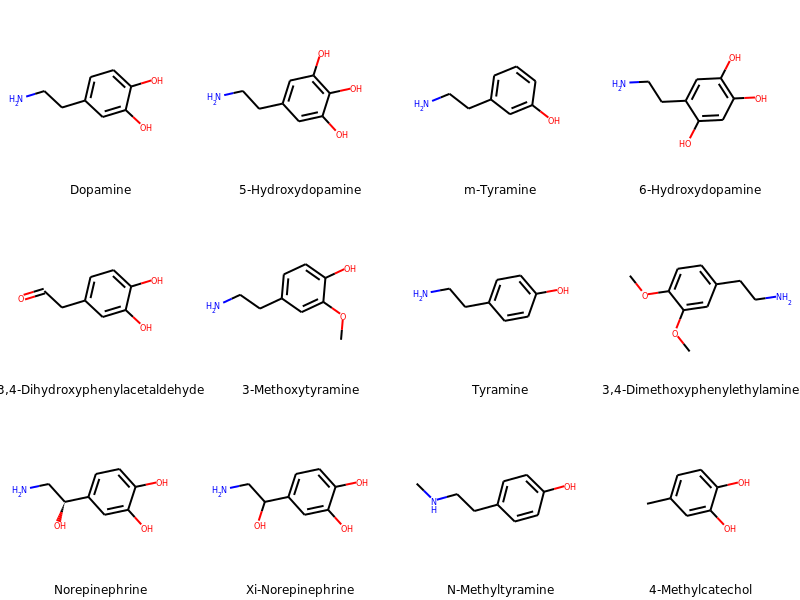

In [6]:
mols = [Chem.MolFromSmiles(smi) for smi in hits["smiles"]]
for i in range(len(mols)): 
    mols[i].SetProp("_Name", hits["refmet_name"][i])
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200,200), legends=[m.GetProp("_Name") for m in mols])